# Microstrip - electrostatic and magnetic field

### Forward problem

In [1]:
import agros2d as a2d

# problem
problem = a2d.problem(clear = True)
problem.coordinate_type = "planar"
problem.mesh_type = "triangle"
problem.parameters["W"] = 0.1
problem.parameters["b"] = 0.4
problem.parameters["h"] = 0.05
problem.parameters["tg"] = 0.01
problem.parameters["ts"] = 0.01

# electrostatic field
electrostatic = problem.field("electrostatic")
electrostatic.analysis_type = "steadystate"
electrostatic.matrix_solver = "umfpack"
electrostatic.number_of_refinements = 1
electrostatic.polynomial_order = 2
electrostatic.adaptivity_type = "disabled"
electrostatic.solver = "linear"

# boundaries
electrostatic.add_boundary("Neumann", 
                           "electrostatic_surface_charge_density", 
                           {"electrostatic_surface_charge_density" : 0})
electrostatic.add_boundary("Voltage", 
                           "electrostatic_potential", 
                           {"electrostatic_potential" : 1})
electrostatic.add_boundary("Ground", 
                           "electrostatic_potential", 
                           {"electrostatic_potential" : 0})

# materials
electrostatic.add_material("Strip", {"electrostatic_permittivity" : 2.6, "electrostatic_charge_density" : 0})
electrostatic.add_material("Air", {"electrostatic_permittivity" : 1, "electrostatic_charge_density" : 0})

# magnetic
magnetic = problem.field("magnetic")
magnetic.analysis_type = "steadystate"
magnetic.matrix_solver = "umfpack"
magnetic.number_of_refinements = 1
magnetic.polynomial_order = 2
magnetic.adaptivity_type = "disabled"
magnetic.solver = "linear"

# boundaries
magnetic.add_boundary("Neumann", "magnetic_surface_current", {"magnetic_surface_current_real" : 0})
magnetic.add_boundary("A = 0", "magnetic_potential", {"magnetic_potential_real" : 0})

# materials
magnetic.add_material("I+", {"magnetic_permeability" : 1,                              
                             "magnetic_current_density_external_real" : "0.5/(W/2*ts)"})
magnetic.add_material("I-", {"magnetic_permeability" : 1, 
                             "magnetic_current_density_external_real" : "-0.5/(b/2*tg)"})
magnetic.add_material("Air", {"magnetic_permeability" : 1})

# geometry
geometry = problem.geometry()
geometry.add_edge(0, 0.6, 0.6, 0.6, boundaries = {"magnetic" : "A = 0"})
geometry.add_edge(0.6, 0.6, 0.6, -0.6, boundaries = {"magnetic" : "A = 0"})
geometry.add_edge(0.6, -0.6, 0, -0.6, boundaries = {"magnetic" : "A = 0"})
geometry.add_edge(0, "-tg", 0, -0.6, boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge(0, 0, 0, "-tg", boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge(0, "-tg", "b/2", "-tg", boundaries = {"electrostatic" : "Ground"})
geometry.add_edge("b/2", "h", "b/2", 0)
geometry.add_edge("W/2", "h", 0, "h", boundaries = {"electrostatic" : "Voltage"})
geometry.add_edge(0, "h+ts", 0, "h", boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge(0, 0, 0, "h", boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge("W/2", "h+ts", "W/2", "h", boundaries = {"electrostatic" : "Voltage"})
geometry.add_edge(0, "h+ts", "W/2", "h+ts", boundaries = {"electrostatic" : "Voltage"})
geometry.add_edge("W/2", "h", "b/2", "h")
geometry.add_edge(0, 0.6, 0, "h+ts", boundaries = {"electrostatic" : "Neumann", "magnetic" : "Neumann"})
geometry.add_edge("b/2", 0, "b/2", "-tg", boundaries = {"electrostatic" : "Ground"})
geometry.add_edge("b/2", 0, 0, 0, boundaries = {"electrostatic" : "Ground"})

geometry.add_label(0.456863, 0.29972, materials = {"electrostatic" : "Air", "magnetic" : "Air"})
geometry.add_label("b/4", "h/2", materials = {"electrostatic" : "Strip", "magnetic" : "Air"})
geometry.add_label("W/4", "h+ts/2", materials = {"electrostatic" : "none", "magnetic" : "I+"})
geometry.add_label("b/4", "-tg/2", materials = {"electrostatic" : "none", "magnetic" : "I-"})

3

### Recipes and optimization (NLopt - BOBYQA)

In [4]:
# recipes 
electrostatic.add_recipe_volume_integral("We", "electrostatic_energy", [0, 1], -1, -1)
magnetic.add_recipe_volume_integral("Wm", "magnetic_energy", [0, 1, 2, 3], -1, -1)

# study
study = problem.add_study("nlopt")
study.add_parameter("W", 0.01, 0.05)
study.add_parameter("b", 0.06, 0.3)
study.add_parameter("h", 0.01, 0.1)
study.add_parameter("tg", 0.001, 0.03)
study.add_parameter("ts", 0.001, 0.03)
study.add_functional("OF", "abs(sqrt((4*Wm/1**2)/(4*We/1**2))-75)", 100)
study.add_functional("Z0", "sqrt((4*Wm/1**2)/(4*We/1**2))", 0)
study.clear_solution = True
study.solve_problem = True
study.settings["xtol_rel"] = 9.9999999999999995e-07
study.settings["xtol_abs"] = 9.9999999999999998e-13
study.settings["ftol_rel"] = 9.9999999999999995e-07
study.settings["ftol_abs"] = 9.9999999999999998e-13
study.settings["n_iterations"] = 20
study.settings["algorithm"] = "ln_bobyqa"

# optimize
study.solve()

### Output - charts

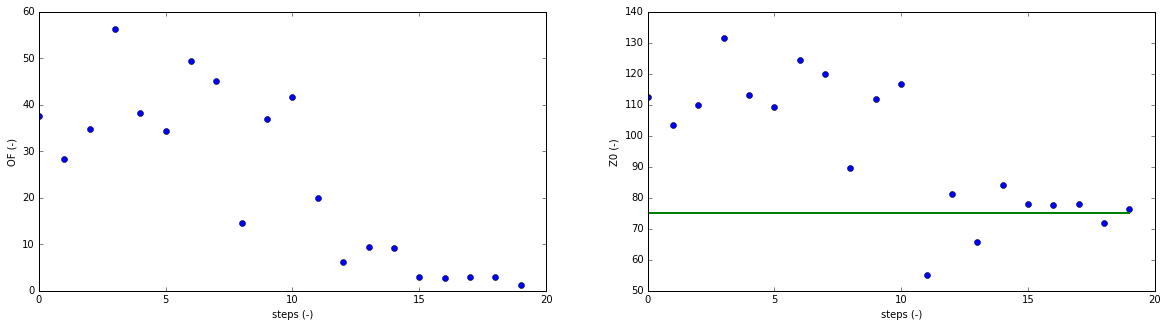

In [5]:
# chart
steps = study.steps()
OF = study.values("OF")
Z0 = study.values("Z0")

%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np

pl.figure(figsize=(20, 5))
pl.subplot(121)
pl.plot(steps, OF, 'o')
pl.xlabel("steps (-)")
pl.ylabel("OF (-)")

pl.subplot(122)
pl.plot(steps, Z0, 'o')
pl.plot(steps, 75*np.ones(len(steps)), linewidth=2)
pl.xlabel("steps (-)")
pl.ylabel("Z0 (-)")

### VTK Output

In [ ]:
computation = study.find_extreme("functional", "OF", True)
computation.solve()

solution_electrostatic = computation.solution("electrostatic")
solution_electrostatic.exportVTK("/tmp/elstat.vtk", 0, 0, "electrostatic_potential", "scalar")

solution_magnetic = computation.solution("magnetic")
solution_magnetic.exportVTK("/tmp/magstat.vtk", 0, 0, "magnetic_potential_real", "scalar")

In [ ]:
import vtk_tools as vt
vt.read_vtk_scalar("/tmp/elstat.vtk")

In [ ]:
vt.read_vtk_scalar("/tmp/magstat.vtk")